# Single Model Training and Evaluation

This notebook contains the code which trains a selected single transformer model. The base models (**BERT**, **RoBERTa** and **Longformer**) are fetched from HuggingFace, after that they are fine-tuned with Pytorch. Training loop, dataloaders and evaluation code are provided in script files.  

The data is read, subsampled to have the same number of rejected and accepted papers (there are much more rejected papers than accepted ones), and split into train/val/test parts. After choosing the optimal parameters (it can be done using the ***HyperparameterOptimisation.ipynb*** notebook), the model is run against the test set. 

The details of the implementation can be found in corresponding scripts as the notebook contains high-level code. 

The code was developed using the **Kaggle** platform, but it is adapted to be run on the **Google Colab** platform.

Essential things to have to run this notebook: 
1. Set the **BASE_PATH** which is the project directory to access the dataset and the code.
2. Make sure you have the data downloaded.
3. Select the hyperparameters.


# Connect to the Google Drive

Firstly, connect to the Google Drive to be able to access files from there to read and store papers.

If other platform is used to run the notebook code, then comment this out. 

In [1]:
from google.colab import drive, files

colab_path = '/content/drive'
drive.mount(colab_path)

Mounted at /content/drive


# Install and Import Required Libraries for Tweets Topic Modelling

In [ ]:
#@title Install Libraries
!pip install transformers

## Import Essential Libraries

In [3]:
import os
import sys
import re
import time
import json
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, Sampler, RandomSampler, SequentialSampler, random_split, Dataset

# Define Paths and Import Local Scripts

Set the absolute paths for **BASE_PATH** and **DATA_PATH**.

In [4]:
BASE_PATH = "/content/drive/MyDrive/Reviewer2"

DATA_PATH = f"{BASE_PATH}/ICLR_Dataset"

module_path = os.path.abspath(BASE_PATH)
if module_path not in sys.path:
    sys.path.append(module_path)


from scripts.data_reading import get_papers_paths, extract_documents_text, subsample_documents
from scripts.train_models import train_transformer_model, train
from scripts.test_models import evaluate_tested_model
from scripts.utils import get_device

# Define Constants, Hyperparameters and Configurations

In [13]:
NUMBER_OF_CLASSES = 2

test_size = 0.2
random_state = 42

# Hyperparameters
epochs = 10
batch_size = 16
learning_rate = 0.000055086239850275174
weight_decay = 0.01
add_paper_metadata = True

# Choose from these models: "bert-base-cased", "roberta-base", "allenai/longformer-base-4096"
model_name = "roberta-base"

# For Longformer, this was used: MAX_TOKENS_NUMBER = 2048
# For BERT and RoBERTa, this was used: MAX_TOKENS_NUMBER = 512
MAX_TOKENS_NUMBER = 512

TEXT_SELECTION_MODES = {"INTRODUCTION_WITH_ABSTRACT": 0, 
                        "INTRODUCTION_WITHOUT_ABSTRACT": 1, 
                        "MIDDLE": 2, 
                        "TAIL": 3,
                        "ABSTRACT_WITH_TAIL": 4}

# Select the text selected mode for the model
mode = TEXT_SELECTION_MODES["INTRODUCTION_WITHOUT_ABSTRACT"]

# Store the tested model 
model_path = f"{BASE_PATH}/Saved_Models"

plt.rcParams["figure.figsize"] = (12, 6)

# Reading and Preprocessing Data for the Models

## Importing the Datasets and Pre-processing 

All details on how the data was preprocessed and split can be found in corresponding script file for data reading and preprocessing.

**Note** that the data reading for the first time of the runtime can run for about an hour for the whole dataset because of long read times from Google Drive. 

In [6]:
paper_and_content_paths = get_papers_paths(DATA_PATH)
documents, labels = extract_documents_text(paper_and_content_paths, mode=mode, add_paper_metadata=add_paper_metadata, MAX_TOKENS_NUMBER=MAX_TOKENS_NUMBER)

0 label means a rejection, whereas 1 - acceptance.

In [7]:
data_df = pd.DataFrame(data={"Docs": documents, "Decision": labels})

data_df.Decision.value_counts()

0    3449
1    1722
Name: Decision, dtype: int64

The data were subsampled because there are about twice more rejected papers than accepted ones. More details on how it is implemented is in the data preprocessing script. 

In [8]:
subsampled_data_df = subsample_documents(data_df, random_state)
subsampled_data_df.Decision.value_counts()

1    1722
0    1722
Name: Decision, dtype: int64

## Training and Testing Split

The data was split into 80% and 20% for train and test sets. The train set is then split into another 80% and 20% for train and validation sets. The data splits are stratified to make sure the class distribution is as nearest to 50% as possible for each split.

In [9]:
training_documents, testing_documents, training_labels, testing_labels = train_test_split(subsampled_data_df.Docs.values, subsampled_data_df.Decision.values, 
                                                                                  test_size=test_size, random_state=random_state, 
                                                                                  stratify=subsampled_data_df.Decision)

training_documents, val_documents, training_labels, val_labels = train_test_split(training_documents, training_labels, 
                                                                                  test_size=test_size, random_state=random_state, 
                                                                                  stratify=training_labels)

print(f"Documents for Training: {len(training_documents)}, Validation: {len(val_documents)}, Testing: {len(testing_documents)}")

Document for Training: 2204, Validation: 551, Testing: 689


## Obtain the Device
Check if there is GPU Available preferably, as it would take a plethora of time to train on a CPU. 

In [10]:
device = get_device()

There are 1 GPU(s) available.
GPU: Tesla T4


# Training the Model

Train the model with the selected parameters. 

============ Transformer roberta-base is now being tested ============



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/1380 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 0.63
  Training epoch took: 0:03:40
  Training Accuracy: 0.61

Running Validation...
  Validation Accuracy: 0.67
Validation Loss: 0.58
Validation took: 0:00:19

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.59
  Training epoch took: 0:03:38
  Training Accuracy: 0.70

Running Validation...
  Validation Accuracy: 0.73
Validation Loss: 0.56
Validation took: 0:00:19

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.57
  Training epoch took: 0:03:38
  Training Accuracy: 0.71

Running Validation...
  Validation Accuracy: 0.73
Validation Loss: 0.56
Validation took: 0:00:19

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.56
  Training epoch took: 0:03:38
  Training Accuracy: 0.71

Running Validation...
  Validation Accuracy: 0.73
Validation Loss: 0.57
Validation took: 0:00:19

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.55


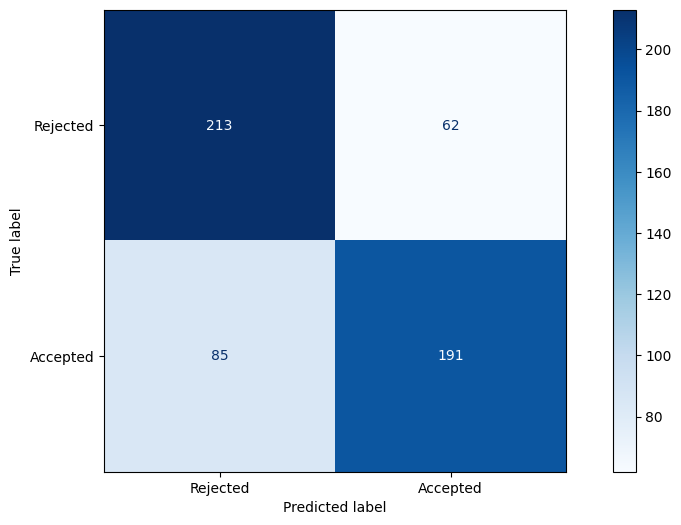

  Validation Accuracy: 0.73
Validation Loss: 0.59
Validation took: 0:00:19

Training complete!
Total training took 0:39:34 (h:mm:ss)


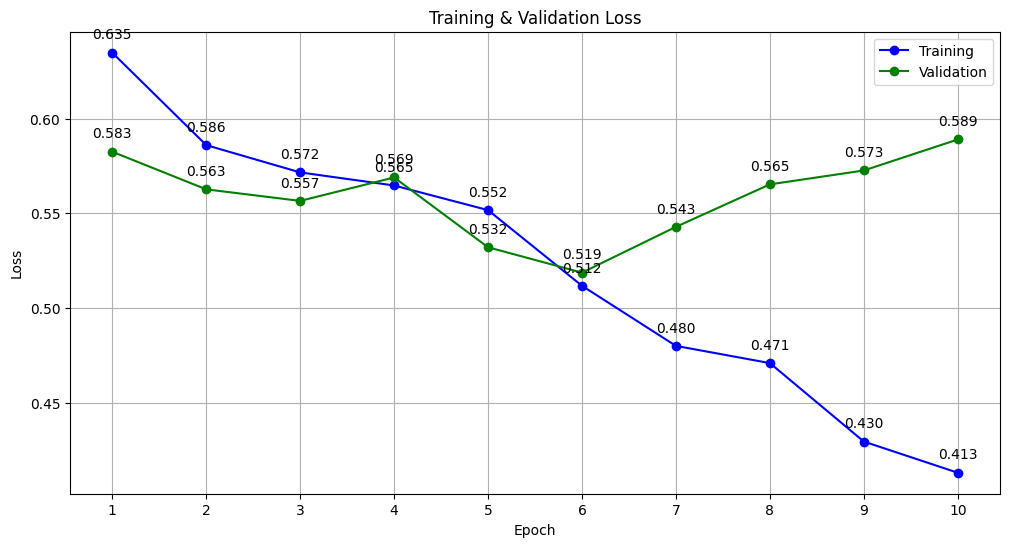

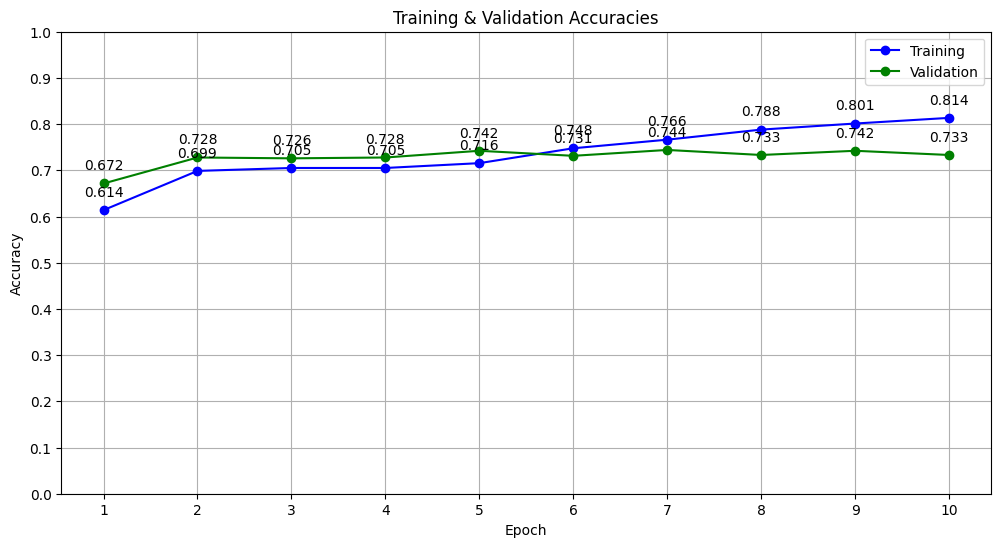

Training Accuracy: 0.8135
Training Loss: 0.4132
Validation Accuracy: 0.7332
Validation Loss: 0.5890

============ Transformer roberta-base has been successfully tested ============




In [14]:
model, model_performance, tokenizer = train_transformer_model(model_name, epochs, batch_size, learning_rate, 
                                                              weight_decay, training_documents, val_documents, 
                                                              training_labels, val_labels, device, 
                                                              MAX_TOKENS_NUMBER, random_state)

# Model Evaluation on the Test Set

After selecting optimal models with train and validation sets, run the model on the test set.

============ Transformer roberta-base evaluation metrics ============
Model Performance metrics:

Accuracy: 0.7475
Precision: 0.7656
Recall: 0.7122
F1 Score: 0.7380


Model Classification report:
              precision    recall  f1-score   support

           0     0.7317    0.7826    0.7563       345
           1     0.7656    0.7122    0.7380       344

    accuracy                         0.7475       689
   macro avg     0.7487    0.7474    0.7471       689
weighted avg     0.7486    0.7475    0.7471       689



Prediction Confusion Matrix:


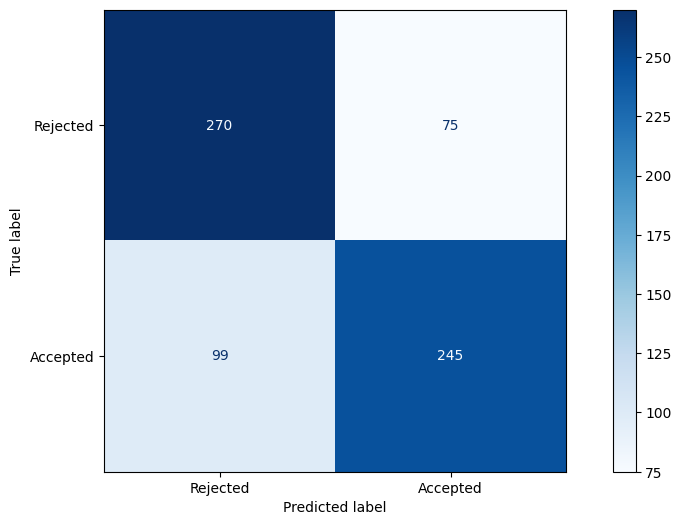

In [15]:
evaluate_tested_model(model, model_name, tokenizer, testing_documents, testing_labels, batch_size, device, MAX_TOKENS_NUMBER, model_path) 